In [1]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 900.2/900.2 kB 726.6 kB/s eta 0:00:0000:0100:01


Iteration:      1,   Func. Count:      8,   Neg. LLF: 2815.8974646474667
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1815.6148504812377
Iteration:      3,   Func. Count:     27,   Neg. LLF: 2344.11972291411
Iteration:      4,   Func. Count:     36,   Neg. LLF: 2622.6193898405922
Iteration:      5,   Func. Count:     44,   Neg. LLF: 2207.357765772479
Iteration:      6,   Func. Count:     52,   Neg. LLF: 1653.1474438123173
Iteration:      7,   Func. Count:     60,   Neg. LLF: 2210.2699871436766
Iteration:      8,   Func. Count:     68,   Neg. LLF: 1652.679085634198
Iteration:      9,   Func. Count:     75,   Neg. LLF: 1652.6734114232809
Iteration:     10,   Func. Count:     82,   Neg. LLF: 1652.6724028819149
Iteration:     11,   Func. Count:     89,   Neg. LLF: 1652.6723081664702
Iteration:     12,   Func. Count:     96,   Neg. LLF: 1652.6722853512797
Iteration:     13,   Func. Count:    103,   Neg. LLF: 1652.6722845195227
Optimization terminated successfully    (Exit mode 0)
 

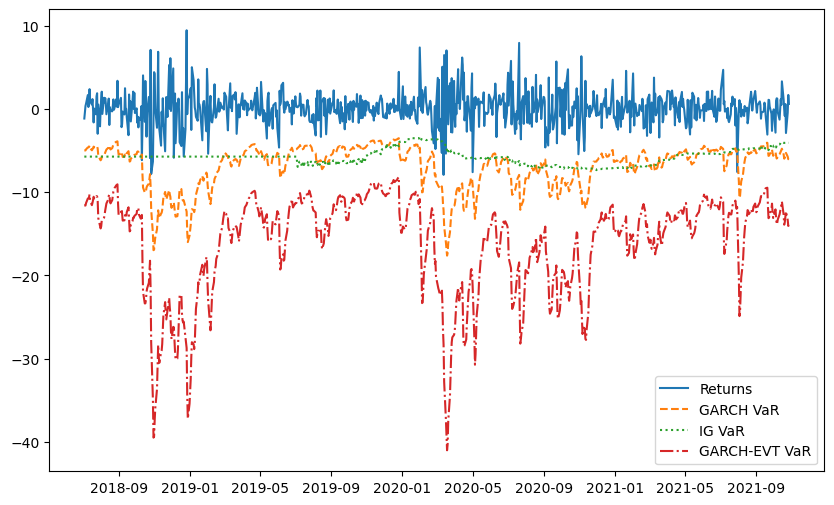

P-value GARCH: 0.001810736939953743
P-value IG: 0.0373257190284636
P-value GARCH-EVT: 0.002077457834397496


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import t, norminvgauss, genextreme
from statsmodels.tsa.stattools import adfuller

# Загрузка данных
data = pd.read_csv('Amazon.csv', index_col=0, parse_dates=True)
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')

# Выбор периода
data = data['2018-07-01':'2022-06-30']


# Расчет доходности
returns = 100 * data['Adj Close'].pct_change().dropna()

# Модель GARCH с константным средним, FIGARCH(1,1,2) и распределением Стьюдента для остатков
garch = arch_model(returns, vol='Figarch', p=1, q=1, dist='t')
garch_res = garch.fit()

# Обратное Гауссовское распределение
params = norminvgauss.fit(returns)
ig = norminvgauss(*params)
window_size = 252
VaR_ig_array = np.empty_like(returns)
VaR_ig_array[:window_size] = -ig.ppf(0.99)

for i in range(window_size, len(returns)):
    window_returns = returns[i - window_size:i]
    window_params = norminvgauss.fit(window_returns)
    window_ig = norminvgauss(*window_params)
    VaR_ig_array[i] = -window_ig.ppf(0.99)

# Комбинация GARCH и EVT
garch_std_resid = garch_res.resid / garch_res.conditional_volatility
exceed_threshold = np.percentile(garch_std_resid, 95)
exceedances = garch_std_resid[garch_std_resid > exceed_threshold] - exceed_threshold
shape, loc, scale = genextreme.fit(exceedances)
gev = genextreme(shape, loc, scale)

# Расчет VaR кривых
VaR_garch = -garch_res.conditional_volatility * t.ppf(0.99, garch_res.params['nu'])
# VaR_ig = -ig.ppf(0.99)
VaR_gev = -garch_res.conditional_volatility * (exceed_threshold + gev.ppf(0.99))

# График с историческими доходностями и VaR кривыми
dates = returns.index

plt.figure(figsize=(10, 6))
plt.plot(dates, returns, label='Returns')
plt.plot(dates, VaR_garch, label='GARCH VaR', linestyle='--')
plt.plot(dates, VaR_ig_array, label='IG VaR', linestyle=':')
plt.plot(dates, VaR_gev, label='GARCH-EVT VaR', linestyle='-.')
plt.legend()
plt.show()

# P-value для каждой модели
adf_garch = adfuller(garch_res.resid - VaR_garch)[1]
adf_ig = adfuller(returns - VaR_ig_array)[1]
adf_gev = adfuller(garch_res.resid - VaR_gev)[1]

# Вывод P-value
print('P-value GARCH:', adf_garch)
print('P-value IG:', adf_ig)
print('P-value GARCH-EVT:', adf_gev)


Можно сделать следующие выводы:

    График исторической доходности и VaR кривых позволяет визуально сравнить риск, связанный с акциями Amazon, согласно разным моделям.

    P-value, рассчитанные с использованием теста Дики-Фуллера, позволяют оценить стационарность временного ряда разности между рядом остатков и VaR кривыми для каждой модели. Так как p-value меньше заданного порога (0.05), можно сделать вывод о стационарности ряда и тем самым о хорошей калибровке модели.

Основываясь на значениях p-value, можно определить, какая модель лучше всего описывает историческую доходность и риски, связанные с акциями Amazon. Наименьшее значение p-value у модели GARCH, это указывает на то что это лучшая модель.